# Convolutional neural network

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar_train = dict(npz_file.items())
print('It is a dictionary with keys:', list(cifar_train.keys()))
cifar_train  

It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


{'pixels': array([[255, 255, 255, ..., 158, 145, 136],
        [208, 216, 210, ...,  49,  57,  78],
        [191, 199, 207, ...,   3,  98, 148],
        ...,
        [254, 254, 254, ...,  61,  56,  58],
        [ 61,  62,  49, ...,  79,  86,  56],
        [110, 108, 122, ..., 153, 142, 146]], dtype=uint8),
 'overfeat': array([[ 3.7246094 , -0.38476562,  1.5878906 , ..., -1.7158203 ,
          1.8623047 , -0.6801758 ],
        [ 3.0859375 ,  0.36206055,  0.36206055, ..., -2.3105469 ,
          2.9140625 , -1.5117188 ],
        [ 4.2265625 ,  1.1328125 , -1.1308594 , ...,  1.6074219 ,
         -1.3417969 , -2.3984375 ],
        ...,
        [ 2.5585938 ,  1.0693359 ,  0.28588867, ..., -1.1923828 ,
          0.8745117 , -0.86621094],
        [ 3.2832031 ,  0.7001953 ,  1.1855469 , ..., -1.0058594 ,
          0.97558594,  1.2060547 ],
        [ 3.9707031 ,  0.28198242,  0.4013672 , ..., -1.3759766 ,
          2.6230469 , -1.2578125 ]], dtype=float32),
 'labels': array([0, 1, 2, ..., 0, 0, 

# pixels

In [2]:
# Convert pixels into floating point numbers
pixels = cifar_train['pixels'].astype(np.float32)
print('pixels:', pixels.shape, pixels.dtype)
#print(pixels)
#print()

# Rescale pixel values between -0.5 and 0.5
pixels_Rescaled = (pixels - 128) / 255
pixels = pixels / 255
#print('pixels:', pixels.shape, pixels.dtype)
#print()
#print(pixels)

pixels_df=pd.DataFrame(pixels) #convert to dataframe
print('pixels:', pixels_df.shape)
print(pixels_df.head())

pixels: (5000, 3072) float32
pixels: (5000, 3072)
       0         1         2         3         4         5         6     \
0  1.000000  1.000000  1.000000  0.984314  0.984314  0.984314  0.984314   
1  0.815686  0.847059  0.823529  0.807843  0.839216  0.780392  0.803922   
2  0.749020  0.780392  0.811765  0.627451  0.701961  0.772549  0.596078   
3  0.760784  0.839216  0.976471  0.760784  0.839216  0.964706  0.776471   
4  0.117647  0.125490  0.074510  0.098039  0.094118  0.047059  0.180392   

       7         8         9       ...         3062      3063      3064  \
0  0.984314  0.984314  0.984314    ...     0.152941  0.196078  0.223529   
1  0.839216  0.760784  0.803922    ...     0.305882  0.203922  0.223529   
2  0.701961  0.776471  0.666667    ...     0.568627  0.011765  0.372549   
3  0.854902  0.972549  0.788235    ...     0.647059  0.658824  0.701961   
4  0.172549  0.101961  0.290196    ...     0.466667  0.564706  0.509804   

       3065      3066      3067      3068      3

# labels

In [4]:
labels=cifar_train['labels']
print('labels:', labels.shape, labels.dtype)
print(labels)

labels: (5000,) int64
[0 1 2 ... 0 0 1]


In [5]:
names=cifar_train['names']
nb_classes = 4
print('names:', names.shape, names.dtype)

names: (4,) <U8


In [6]:
labels_df=pd.DataFrame(labels) #convert to dataframe
print('labels_df:', labels_df.shape)
print(labels_df.head())

labels_df: (5000, 1)
   0
0  0
1  1
2  2
3  1
4  1


# split the data points into train/valid/test

In [7]:
# Rescale input data
scaler = StandardScaler()
pixels_Rescaled = scaler.fit_transform(pixels_Rescaled)

In [8]:
# Reshape images: 32 by 32 with 3 (RGB) color channels
pixels_reshaped = pixels_Rescaled.reshape(-1, 32, 32, 3)
print('pixels_reshaped:', pixels_reshaped.shape, pixels_reshaped.dtype)
#print(pixels_reshaped)

pixels_reshaped: (5000, 32, 32, 3) float32


In [9]:
from sklearn.model_selection import train_test_split # Split data
X_tr, X_te, y_tr, y_te = train_test_split(pixels_reshaped, labels ,test_size=1000, random_state=0, stratify=labels)

# Create validation and test sets
X_tr2, X_valid, y_tr2,y_valid = train_test_split(X_tr, y_tr, test_size=800, random_state=0, stratify=y_tr)

print('Train:', X_tr.shape, y_tr.shape)
print('Test1:', X_te.shape, y_te.shape)
print('Train/X_tr2:', X_tr2.shape, y_tr2.shape)
print('Valid:', X_valid.shape, y_valid.shape)

Train: (4000, 32, 32, 3) (4000,)
Test1: (1000, 32, 32, 3) (1000,)
Train/X_tr2: (3200, 32, 32, 3) (3200,)
Valid: (800, 32, 32, 3) (800,)


In [10]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

## - Create and train a ConvNet


In [11]:
# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    print('Input:', X.shape)
    
    # Convolutional layer (64 filters, 5x5, stride: 2)
    conv1 = tf.layers.conv2d(
        X, 64, (5, 5), (2, 2), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv1'
    )
    print('Convolutional layer:', conv1.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), 'SAME')
    print('Maxpool:', pool1.shape)
    
    # Convolutional layer (64 filters, 3x3, stride: 1)
    conv2 = tf.layers.conv2d(
        pool1, 64, (3, 3), (1, 1), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv2'
    )
    print('Convolutional layer:', conv2.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), 'SAME')
    print('Maxpool:', pool2.shape)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    print('Flatten:', flat_output.shape)
    
    # Dropout
    training = tf.placeholder(dtype=tf.bool)
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)
    
    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output, 256, # 256 hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer:', fc1.shape)
    
    # Output layer
    logits = tf.layers.dense(
        fc1, 10, # One output unit per category
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Output layer:', logits.shape)
    
    # Kernel of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # L2 regularization
    #L2 term
    l2_term = tf.nn.l2_loss(conv_kernels)
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    # Loss function
    loss = mean_ce + alpha * l2_term
    # Training operation
    train_op = gd.minimize(loss)    
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Input: (?, 32, 32, 3)
Convolutional layer: (?, 16, 16, 64)
Maxpool: (?, 8, 8, 64)
Convolutional layer: (?, 8, 8, 64)
Maxpool: (?, 4, 4, 64)
Flatten: (?, 1024)
Dropout: (?, 1024)
Fully-connected layer: (?, 256)
Output layer: (?, 10)


In [12]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_tr2, y_tr2, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: True, # Apply dropout
                alpha: 0.1 # Regularization strength
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} batch_acc: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
            training: False
    })
    print('Test accuracy: {:.3f}'.format(test_acc))

Epoch 1 - valid: 0.509 batch_acc: 0.403 (mean)
Epoch 2 - valid: 0.561 batch_acc: 0.519 (mean)
Epoch 3 - valid: 0.605 batch_acc: 0.555 (mean)
Epoch 4 - valid: 0.604 batch_acc: 0.587 (mean)
Epoch 5 - valid: 0.642 batch_acc: 0.619 (mean)
Epoch 6 - valid: 0.668 batch_acc: 0.647 (mean)
Epoch 7 - valid: 0.660 batch_acc: 0.686 (mean)
Epoch 8 - valid: 0.692 batch_acc: 0.681 (mean)
Epoch 9 - valid: 0.688 batch_acc: 0.714 (mean)
Epoch 10 - valid: 0.716 batch_acc: 0.734 (mean)
Epoch 11 - valid: 0.710 batch_acc: 0.743 (mean)
Epoch 12 - valid: 0.759 batch_acc: 0.751 (mean)
Epoch 13 - valid: 0.714 batch_acc: 0.752 (mean)
Epoch 14 - valid: 0.726 batch_acc: 0.763 (mean)
Epoch 15 - valid: 0.736 batch_acc: 0.778 (mean)
Epoch 16 - valid: 0.735 batch_acc: 0.786 (mean)
Epoch 17 - valid: 0.755 batch_acc: 0.791 (mean)
Epoch 18 - valid: 0.750 batch_acc: 0.814 (mean)
Epoch 19 - valid: 0.777 batch_acc: 0.824 (mean)
Epoch 20 - valid: 0.761 batch_acc: 0.822 (mean)
Epoch 21 - valid: 0.752 batch_acc: 0.830 (mean)
E

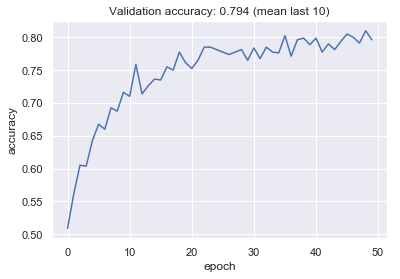

In [13]:
# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 10)'.format(
    np.mean(valid_acc_values[-10:]) # last values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [14]:
# Grid search
# Parameter tuned
from sklearn.model_selection import ParameterGrid
grid = ParameterGrid({
    'alpha': [0.00010,0.00030,0.00060,0.00090],  # Regularization strength
    'lr': [0.0010]              # Learning rate
})

test_scores = []

# loop ----
for i, params_dict  in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))    
    
    # Validation accuracy
    valid_acc_values = []

    with tf.Session(graph=graph) as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        # Set seed
        np.random.seed(0)

        # Train several epochs
        for epoch in range(50):
            # Accuracy values (train) after each batch
            batch_acc = []

            # Get batches of data
            for X_batch, y_batch in get_batches(X_tr2, y_tr2, 64):
                # Run training and evaluate accuracy
                _, acc_value = sess.run([train_op, accuracy], feed_dict={
                    X: X_batch,
                    y: y_batch,
                    lr: params_dict['lr'], # Learning rate
                    training: True, # Apply dropout
                    alpha: params_dict['alpha'] # Regularization strength
                })

                # Save accuracy (current batch)
                batch_acc.append(acc_value)

            # Evaluate validation accuracy
            valid_acc = sess.run(accuracy, feed_dict={
                X: X_valid,
                y: y_valid,
                training: False # Do not apply dropout
                })
            valid_acc_values.append(valid_acc)

            # Print progress
            #print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            #    epoch+1, valid_acc, np.mean(batch_acc)))


        # Evaluate test accuracy
        test_acc = sess.run(accuracy, feed_dict={
            X: X_te,
            y: y_te,
            training: False # Do not apply dropout        
        })
        print('Last Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        print('Test accuracy: {:.3f}'.format(test_acc))
   
    # Get train/test scores   
    params_dict['Valid_accuracy'] = valid_acc
    params_dict['Test_accuracy'] = test_acc  

     # Save result
    test_scores.append(params_dict)
#Loop End---
print('done')

Combination 1/4
Last Epoch 50 - valid: 0.795 train: 0.967 (mean)
Test accuracy: 0.815
Combination 2/4
Last Epoch 50 - valid: 0.809 train: 0.965 (mean)
Test accuracy: 0.816
Combination 3/4
Last Epoch 50 - valid: 0.796 train: 0.962 (mean)
Test accuracy: 0.815
Combination 4/4
Last Epoch 50 - valid: 0.801 train: 0.964 (mean)
Test accuracy: 0.799
done


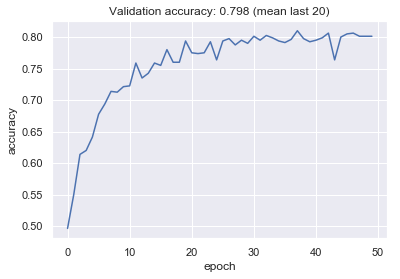

In [15]:
# Plot accuracy values of last run
plt.plot(valid_acc_values)
#plt.plot(batch_acc)
plt.title('Validation accuracy: {:.3f} (mean last 20)'.format(
    np.mean(valid_acc_values[-20:])
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [16]:
# Create DataFrame with scores
test_scores_df=pd.DataFrame(test_scores)
df1=test_scores_df.sort_values(by='Test_accuracy', ascending=False)
df1.head(9)

,Test_accuracy,Valid_accuracy,alpha,lr
1,0.816,0.80875,0.0003,0.001
0,0.815,0.79500,0.0001,0.001
2,0.815,0.79625,0.0006,0.001
3,0.799,0.80125,0.0009,0.001


In [17]:
# Print maximum accuracy
idx = test_scores_df.Test_accuracy.idxmax() # Index of maximum value
max_accuracy = test_scores_df.Test_accuracy[idx]
print('Convolutional network accuracy (test set):  {:.3f}'
      .format(max_accuracy))

Convolutional network accuracy (test set):  0.816


##  - Visualize kernels


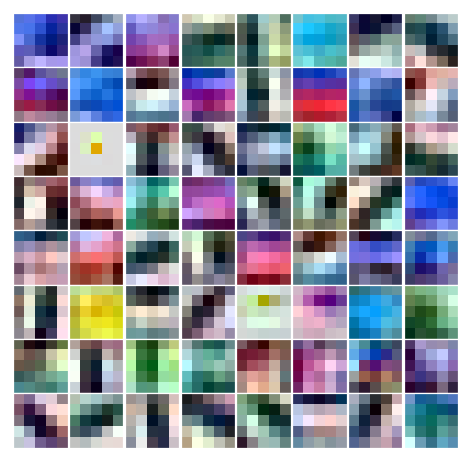

In [18]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()

# Save Result

In [19]:
# Load data
import pandas as pd
Result_df = pd.read_csv('Result_df.csv')
print(Result_df.head(9))

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.802
4        svm rbf          0.839
5       logistic          0.833
6          fc nn          0.840
7            cnn          0.816


In [20]:
Result_df.iloc[7,1]=max_accuracy
print(Result_df.head(9))

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.802
4        svm rbf          0.839
5       logistic          0.833
6          fc nn          0.840
7            cnn          0.816


In [21]:
#Write Result as Dataframe to file
Result_df.to_csv('Result_df.csv', index=False, float_format='%.3f')